## Imports and global parameters

In [2]:
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [3]:
import tensorflow as tf
import keras
import optuna
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import sys
import random
import logging
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, root_mean_squared_error
from keras import layers
from optuna.visualization import plot_contour, plot_param_importances

2024-10-08 21:42:53.342946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 21:42:53.342971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 21:42:53.343937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 21:42:53.348971: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 21:42:53.936035: W tensorflow/compiler/tf2

In [4]:
!mkdir -p ../models

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)

[]


2024-10-08 21:42:55.315195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-08 21:42:55.354501: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
IMG_PATH = '../data/img/'
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
IM_SHAPE = (500, 500, 3)
MAX_EPOCHS = 40
MODEL_SELECTION_STEPS = 50
USE_DATASETS_FROM_PAPER = False

BACKBONE_MODEL = 'efficientnet'

# Data preprocessing

### Read csv files and create datasets

In [6]:
df = pd.read_csv('../data/dataset.csv')
df['id'] = df['id'].apply(lambda id: os.path.join(IMG_PATH, id))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5933 entries, 0 to 5932
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5933 non-null   object 
 1   translErr  5933 non-null   float64
 2   rotErr     5933 non-null   float64
 3   area       5933 non-null   float64
dtypes: float64(3), object(1)
memory usage: 185.5+ KB


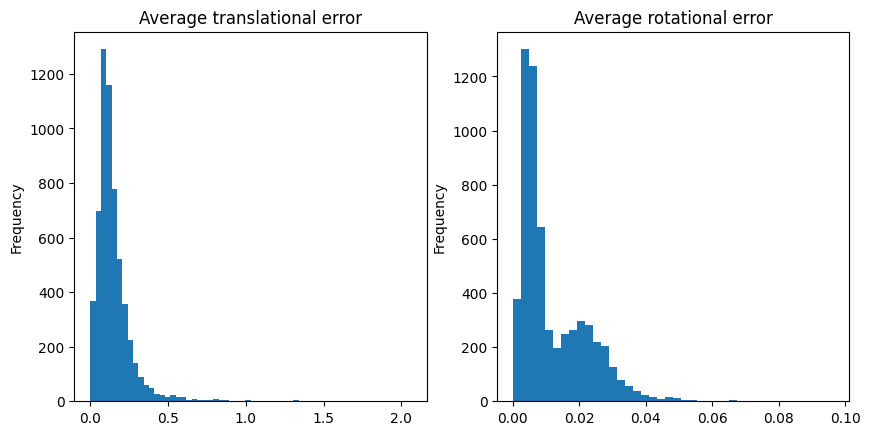

In [7]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=60, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

#### Feature Clipping
To perform data rescaling, every value that is above $k = 0.995$-quantile is clipped to $k$.

In [8]:
rot = df['rotErr'].copy()
rot[rot > rot.quantile(.995)] = rot.quantile(.995)
df['rotErr'] = rot

transl = df['translErr'].copy()
transl[transl > transl.quantile(.995)] = transl.quantile(.995)
df['translErr'] = transl

#### Data rescaling

In [9]:
rescaler_rot = sk.preprocessing.MinMaxScaler()
rescaler_transl = sk.preprocessing.MinMaxScaler()
df['rotErr'] = rescaler_rot.fit_transform(df['rotErr'].values.reshape(-1,1)).squeeze()
df['translErr'] = rescaler_transl.fit_transform(df['translErr'].values.reshape(-1,1)).squeeze()
df['area'] /= df['area'].max()
df.head()

,id,translErr,rotErr,area
0,../data/img/32-G5.png,0.651595,1.000000,0.097354
1,../data/img/32-G7.png,0.777247,0.984398,0.193957
2,../data/img/32-G9.png,0.546994,0.718890,0.101897
3,../data/img/32-D8.png,0.614334,0.846781,0.147976
4,../data/img/W31-2.png,0.263803,0.349292,0.081962


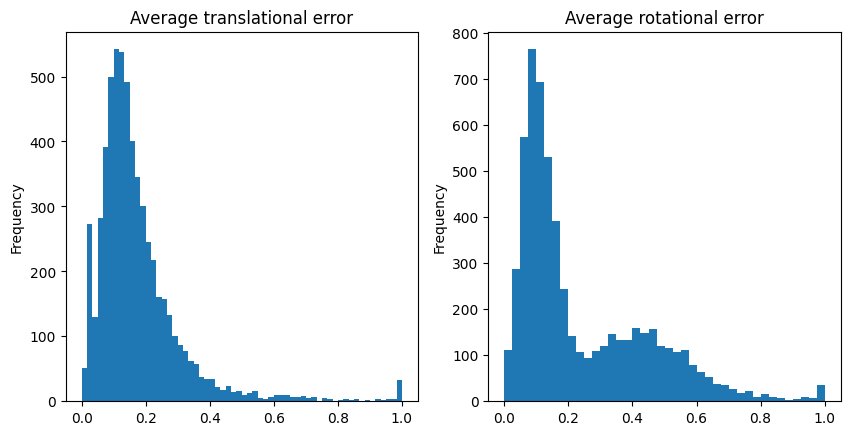

In [10]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
df['translErr'].plot.hist(bins=60, title='Average translational error', ax=ax[0])
df['rotErr'].plot.hist(bins=40, title='Average rotational error', ax=ax[1])
plt.show()

### Data partitioning and dataset creation

In [9]:
if USE_DATASETS_FROM_PAPER:
    suffixes = ['train', 'val', 'test']
    df_splits = []
    for suff in suffixes:
        temp_df = pd.read_csv(f'../data/env_ids_{suff}.csv')
        temp_df.env = temp_df.env.apply(lambda x: f'data/img/{x}.png')
        temp_df = df[df['id'].isin(temp_df.env)].drop_duplicates(subset='id')
        df_splits.append(temp_df)

    train_df, val_df, test_df = df_splits

else:
    train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)    

In [10]:
def load_image(id: tf.types.experimental):
    image = tf.io.read_file(id)
    image = tf.image.decode_png(image, channels=3)
    return image

def data_augmentation(img: np.ndarray):
    rotation = random.randint(0, 3)
    img = tf.image.rot90(img, k=rotation)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_flip_left_right(img)
    return img


def load_dataset(df: pd.DataFrame, augment=False) -> tf.data.Dataset:
    X = tf.data.Dataset.from_tensor_slices(df["id"].values)
    area = tf.data.Dataset.from_tensor_slices(df["area"].values)
    Y = tf.data.Dataset.from_tensor_slices(df[["translErr", "rotErr"]].values)

    X = X.map(load_image, num_parallel_calls=AUTO)
    
    if augment:
        X = X.map(lambda img: data_augmentation(img), num_parallel_calls=AUTO)

    dataset = tf.data.Dataset.zip((X, area), Y)
    dataset = dataset.shuffle(4500)
    dataset = dataset.batch(
        batch_size=BATCH_SIZE,
        num_parallel_calls=AUTO,
        deterministic=False,
        drop_remainder=False,
    )
    dataset = dataset.prefetch(AUTO)
    return dataset


train_data = load_dataset(train_df, augment=True)
val_data = load_dataset(val_df)
test_data = load_dataset(test_df)

#### Show a sample datapoint

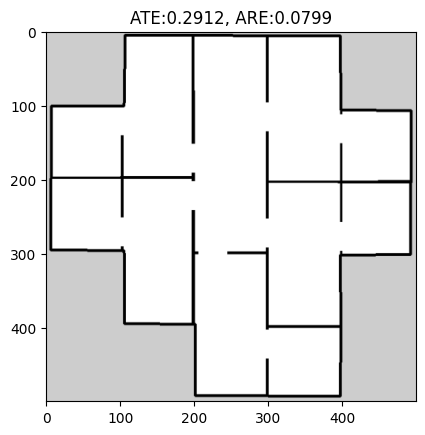

In [15]:
for r in val_data.take(1).as_numpy_iterator():
    r, l = r[0], r[1]
    plt.imshow(r[0][0], cmap='gray')
    plt.title(f"ATE:{l[0][0]:.4f}, ARE:{l[0][1]:.4f}")
    plt.show()
    break

#### Support functions

In [16]:
def plot_history(hst: keras.callbacks.History):
    metrics = ["loss"]
    _, ax = plt.subplots(1, len(metrics), figsize=(10, 10))
    for _, metric in enumerate(metrics):
        ax.plot(hst.history[metric])
        ax.plot(hst.history["val_" + metric])
        ax.set(title="model " + metric, ylabel=metric, xlabel="epoch", ylim=[0,0.10])
        ax.legend([metric, "val_" + metric], loc="upper left")
    plt.show()

def free_memory(model):
    del model
    keras.backend.clear_session()

## Define the CNN structure

In [17]:
def _build_efficientNet(input: layers.Layer):
    effNet = keras.applications.EfficientNetV2B3(include_top=False, pooling="avg")
    effNet.trainable = False
    return effNet(input)


def _build_mobileNet(input: layers.Layer):
    mobNet = keras.applications.MobileNetV3Large(include_top=False, pooling="avg")
    mobNet.trainable = False
    return mobNet(input)


def build_model(config: dict) -> keras.Model:  
    backbone_builder = {
        "efficientnet": _build_efficientNet,
        "mobilenet": _build_mobileNet,
    }
    backbone = backbone_builder[BACKBONE_MODEL]

    img_input = layers.Input(shape=IM_SHAPE, name='image_input')
    x = backbone(img_input)

    # skip connection
    area_input = layers.Input(shape=(1,), name='area_input')
    x = layers.Concatenate()([area_input, x])

    for i in range(config["nLayers"]):
        x = layers.Dense(units=config[f"layer{i}_units"], name=f"dense_{i}")(x)
        if config["batchNorm"]:
            x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)

        if config["dropout"]:
            x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, "relu", name="out_layer")(x)

    model = keras.Model(inputs=[img_input, area_input], outputs=out, name=f"{BACKBONE_MODEL}_model")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config["lr"]), loss="mse"
    )
    return model

In [18]:
baselineHyperparameters = {
    "lr": 1e-4,
    "nLayers": 3,
    "batchNorm": True,
    "dropout": False,
    "layer0_units": 1024,
    "layer1_units": 512,
    "layer2_units": 128,
}
m = build_model(baselineHyperparameters)

### Train with baseline config

In [49]:
es = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

history = m.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, epochs=MAX_EPOCHS, callbacks=[es])
m.save('models/efficientNet_model_baseline.keras')

free_memory(m)

Epoch 1/60
64/64 [==============================] - 32s 481ms/step - loss: 0.4876 - val_loss: 0.0467
Epoch 2/60
64/64 [==============================] - 32s 482ms/step - loss: 0.1551 - val_loss: 0.0722
Epoch 3/60
64/64 [==============================] - 33s 487ms/step - loss: 0.0844 - val_loss: 0.0532
Epoch 4/60
64/64 [==============================] - 33s 491ms/step - loss: 0.0658 - val_loss: 0.0458
Epoch 5/60
64/64 [==============================] - 33s 494ms/step - loss: 0.0599 - val_loss: 0.0472
Epoch 6/60
64/64 [==============================] - 33s 496ms/step - loss: 0.0590 - val_loss: 0.0483
Epoch 7/60
64/64 [==============================] - 33s 494ms/step - loss: 0.0565 - val_loss: 0.0510
Epoch 8/60
64/64 [==============================] - 33s 495ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 9/60
64/64 [==============================] - 33s 495ms/step - loss: 0.0547 - val_loss: 0.0475
Epoch 10/60
64/64 [==============================] - 33s 497ms/step - loss: 0.0526 - val_lo

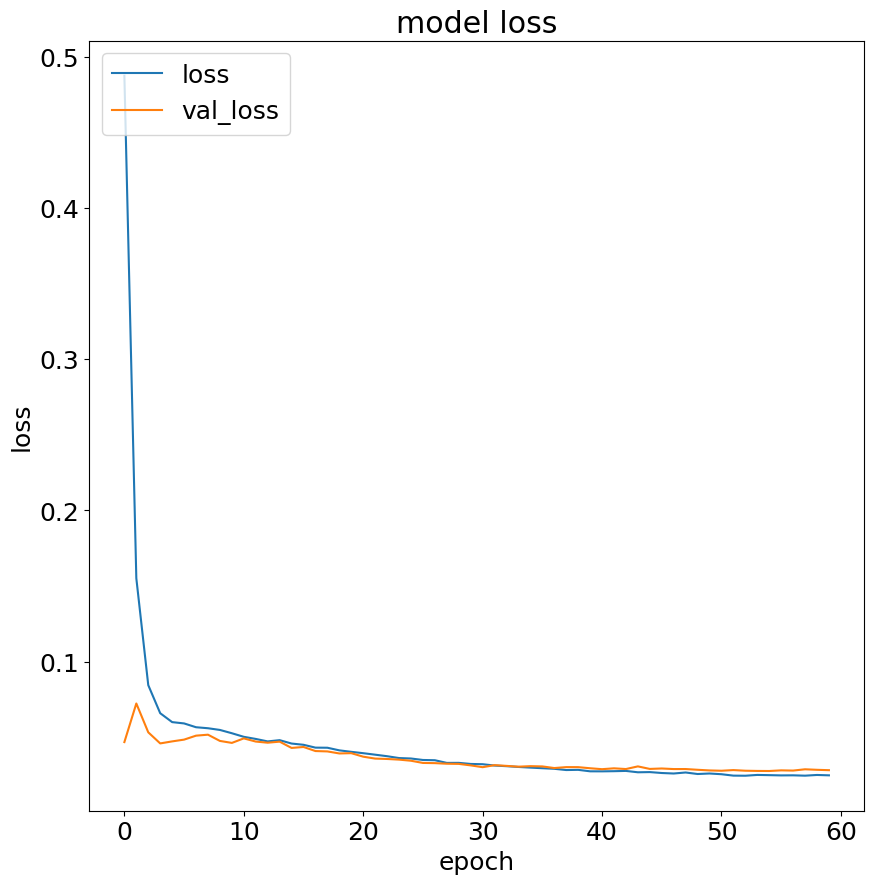

In [50]:
plot_history(history)

### Hyperparameter tuning

In [20]:
def objective(trial: optuna.Trial) -> float:
    tf.keras.backend.clear_session()
    best_val_loss = np.inf
    patience = 0
    config = {
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "nLayers": trial.suggest_int("nLayers", 1, 6),
        "batchNorm": trial.suggest_categorical("batchNorm", [True, False]),
        "dropout": trial.suggest_categorical("dropout", [True, False]),
    }
    
    layerDim = [64, 128, 256, 512, 1024, 2048]
    for i in range(config["nLayers"]):
        config[f"layer{i}_units"] = trial.suggest_categorical(
            f"layer{i}_units", layerDim
        )

    model = build_model(config)

    for train_step in range(MAX_EPOCHS):
        history = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data)
        val_loss = history.history["val_loss"][0]
        # Implement earlystopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1

        if patience > 7:
            break

        trial.report(val_loss, train_step)
        if trial.should_prune():
            del model
            raise optuna.TrialPruned()
    del model
    return best_val_loss

In [22]:
def kFoldCV(hyperPar: dict, training_set: pd.DataFrame, k: int) -> float:
    df = training_set.reset_index(drop=True)
    kf = KFold(n_splits=k, shuffle=True)
    scores = []
    for trainIdx, valIdx in kf.split(df):
        train_data = load_dataset(df.iloc[trainIdx], augment=True)
        val_data = load_dataset(df.iloc[valIdx])

        model = build_model(hyperPar)
        es = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
        model.fit(train_data, 
                  batch_size=BATCH_SIZE,
                  validation_data=val_data,
                  epochs=MAX_EPOCHS,
                  callbacks=[es]
                  )
        
        result = model.evaluate(val_data, batch_size=BATCH_SIZE)
        scores.append(result)

        free_memory(model)

    return np.avg(scores)  

## Optimize EfficientNetV2

In [ ]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='efficientNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

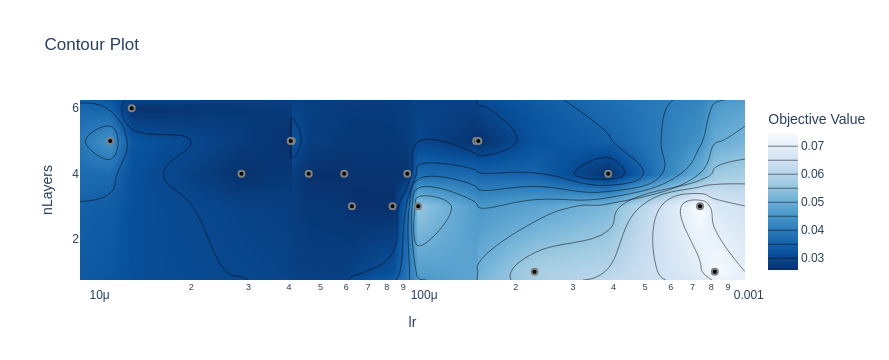

In [42]:
plot_contour(study, params=['lr', 'nLayers'])

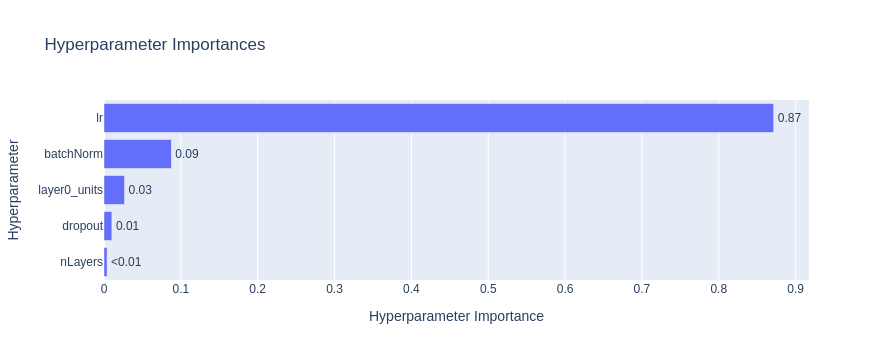

In [32]:
plot_param_importances(study)

In [35]:
study.best_params

{'lr': 0.00021330992764554714,
 'nLayers': 3,
 'batchNorm': False,
 'dropout': False,
 'layer0_units': 128,
 'layer1_units': 512,
 'layer2_units': 64}

In [ ]:
# CV_loss_effNet = kFoldCV(study.best_params, train_df, 5)

In [24]:
#model = build_model(study.best_params)
model = build_model(p)
es = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
hst_optimized = model.fit(train_data, epochs=MAX_EPOCHS, validation_data=val_data, batch_size=BATCH_SIZE, callbacks=[es])
model.save(f'models/efficientNet_model_{time.strftime("%d%b_%I_%M%p")}.keras')

test_loss_effNet = model.evaluate(test_data)

free_memory(model)

Epoch 1/40
64/64 [==============================] - 40s 500ms/step - loss: 0.0330 - val_loss: 0.0282
Epoch 2/40
64/64 [==============================] - 33s 481ms/step - loss: 0.0264 - val_loss: 0.0274
Epoch 3/40
64/64 [==============================] - 33s 483ms/step - loss: 0.0255 - val_loss: 0.0263
Epoch 4/40
64/64 [==============================] - 33s 487ms/step - loss: 0.0249 - val_loss: 0.0280
Epoch 5/40
64/64 [==============================] - 33s 493ms/step - loss: 0.0246 - val_loss: 0.0262
Epoch 6/40
64/64 [==============================] - 33s 492ms/step - loss: 0.0247 - val_loss: 0.0261
Epoch 7/40
64/64 [==============================] - 33s 493ms/step - loss: 0.0245 - val_loss: 0.0261
Epoch 8/40
64/64 [==============================] - 33s 492ms/step - loss: 0.0245 - val_loss: 0.0266
Epoch 9/40
64/64 [==============================] - 33s 492ms/step - loss: 0.0245 - val_loss: 0.0258
Epoch 10/40
64/64 [==============================] - 33s 491ms/step - loss: 0.0240 - val_lo

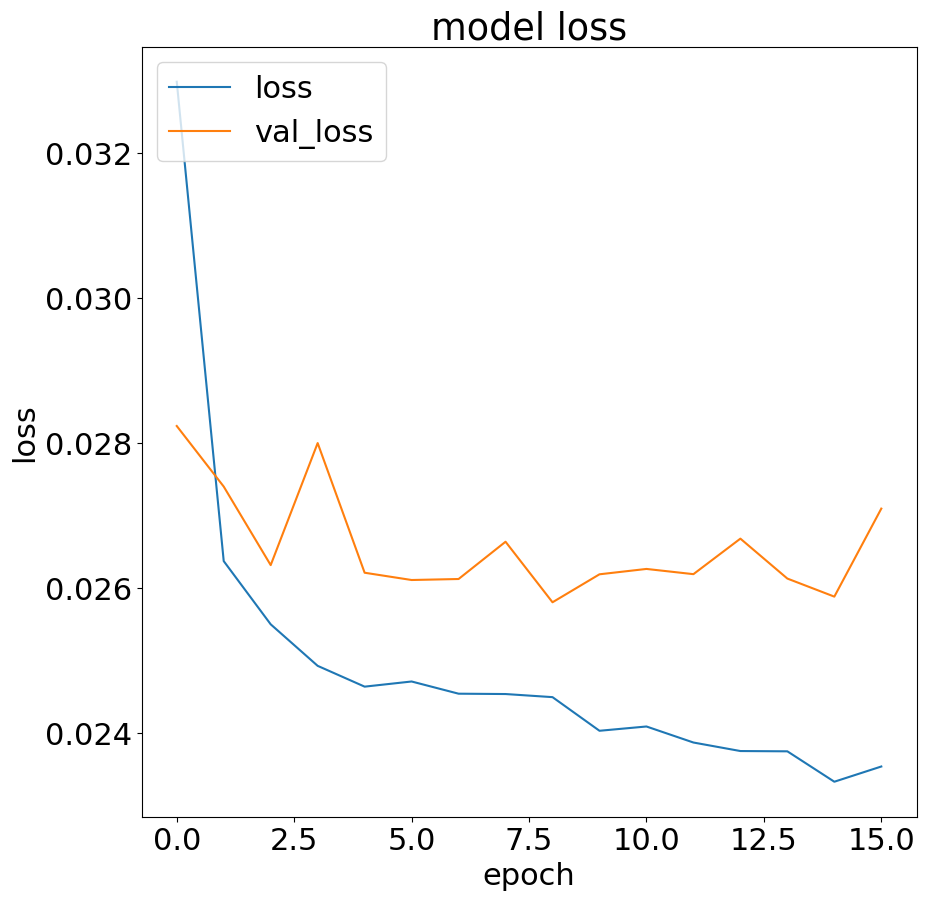

In [25]:
plot_history(hst_optimized)

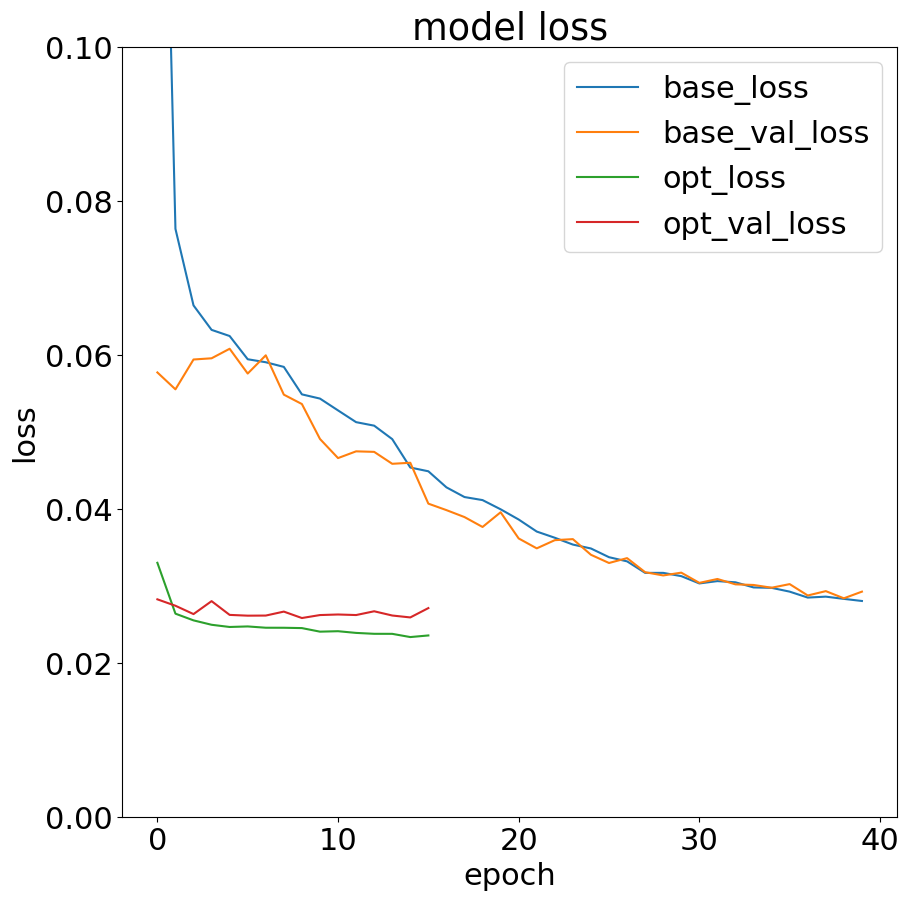

In [26]:
metrics = ["loss"]
_, ax = plt.subplots(1, len(metrics), figsize=(10, 10))
for _, metric in enumerate(metrics):
    ax.plot(history.history[metric])
    ax.plot(history.history["val_" + metric])
    ax.plot(hst_optimized.history[metric])
    ax.plot(hst_optimized.history["val_" + metric])
    ax.set(title="model " + metric, ylabel=metric, xlabel="epoch", ylim=[0,0.10])
    ax.legend(['base_loss', "base_val_loss", 'opt_loss', 'opt_val_loss'], loc="upper right")
plt.show()

## Optimize MobileNetV3_large

In [21]:
BACKBONE_MODEL = 'mobilenet'

### Train MobileNet with baseline config

In [20]:
m = build_model(baselineHyperparameters)
es = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
history = m.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, epochs=MAX_EPOCHS, callbacks=[es])
m.save('models/mobileNet_model_baseline.keras')

free_memory(m)

Epoch 1/40
64/64 [==============================] - 19s 214ms/step - loss: 0.2465 - val_loss: 0.0632
Epoch 2/40
64/64 [==============================] - 14s 194ms/step - loss: 0.0799 - val_loss: 0.0603
Epoch 3/40
64/64 [==============================] - 14s 194ms/step - loss: 0.0631 - val_loss: 0.0598
Epoch 4/40
64/64 [==============================] - 14s 193ms/step - loss: 0.0605 - val_loss: 0.0644
Epoch 5/40
64/64 [==============================] - 14s 194ms/step - loss: 0.0584 - val_loss: 0.0626
Epoch 6/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0557 - val_loss: 0.0603
Epoch 7/40
64/64 [==============================] - 14s 196ms/step - loss: 0.0511 - val_loss: 0.0587
Epoch 8/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0485 - val_loss: 0.0571
Epoch 9/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0463 - val_loss: 0.0561
Epoch 10/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0446 - val_lo

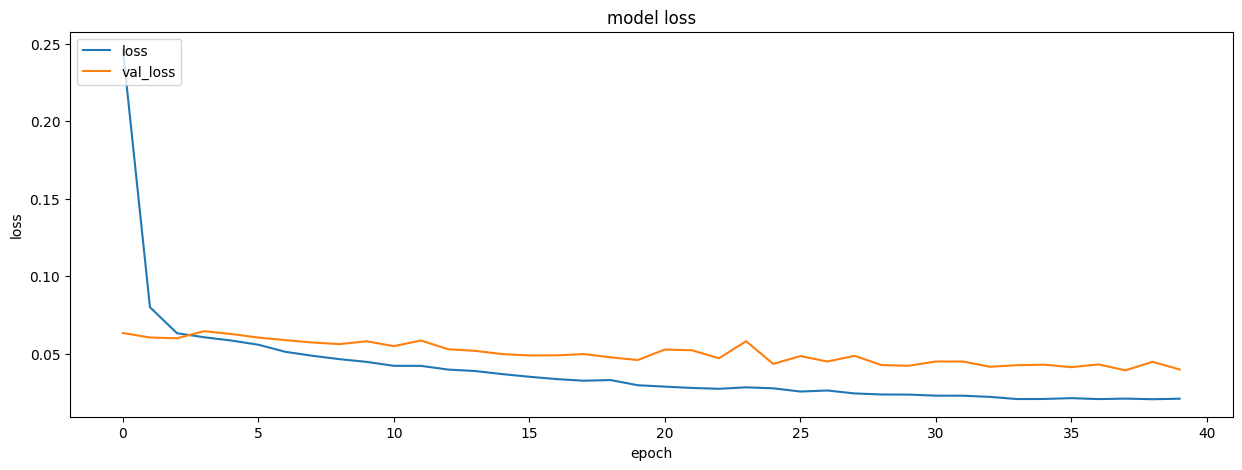

In [21]:
plot_history(history)

### Optimize with optuna

In [ ]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='mobileNet_study'
)

study.enqueue_trial(baselineHyperparameters)    # Test on baseline parameters first and optimize from there
study.optimize(objective, n_trials=MODEL_SELECTION_STEPS, gc_after_trial=True)

In [ ]:
plot_contour(study, params=['lr', 'nLayers'])

In [ ]:
plot_param_importances(study)

In [ ]:
study.best_params

In [ ]:
# CV_loss_mobNet = kFoldCV(study.best_params, train_df, 5)

In [28]:
model = build_model(study.best_params)
es = keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
hst = model.fit(train_data, epochs=MAX_EPOCHS, validation_data=val_data, batch_size=BATCH_SIZE, callbacks=[es])
model.save(f'models/mobileNet_model_{time.strftime("%d%b_%I_%M%p")}.keras')

test_loss_mobNet = model.evaluate(test_data)

free_memory(model)

Epoch 1/40
64/64 [==============================] - 17s 206ms/step - loss: 0.0271 - val_loss: 0.0262
Epoch 2/40
64/64 [==============================] - 14s 196ms/step - loss: 0.0247 - val_loss: 0.0261
Epoch 3/40
64/64 [==============================] - 14s 194ms/step - loss: 0.0244 - val_loss: 0.0273
Epoch 4/40
64/64 [==============================] - 14s 196ms/step - loss: 0.0240 - val_loss: 0.0254
Epoch 5/40
64/64 [==============================] - 14s 196ms/step - loss: 0.0240 - val_loss: 0.0262
Epoch 6/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0235 - val_loss: 0.0262
Epoch 7/40
64/64 [==============================] - 14s 196ms/step - loss: 0.0231 - val_loss: 0.0254
Epoch 8/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0233 - val_loss: 0.0307
Epoch 9/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0229 - val_loss: 0.0260
Epoch 10/40
64/64 [==============================] - 14s 195ms/step - loss: 0.0225 - val_lo

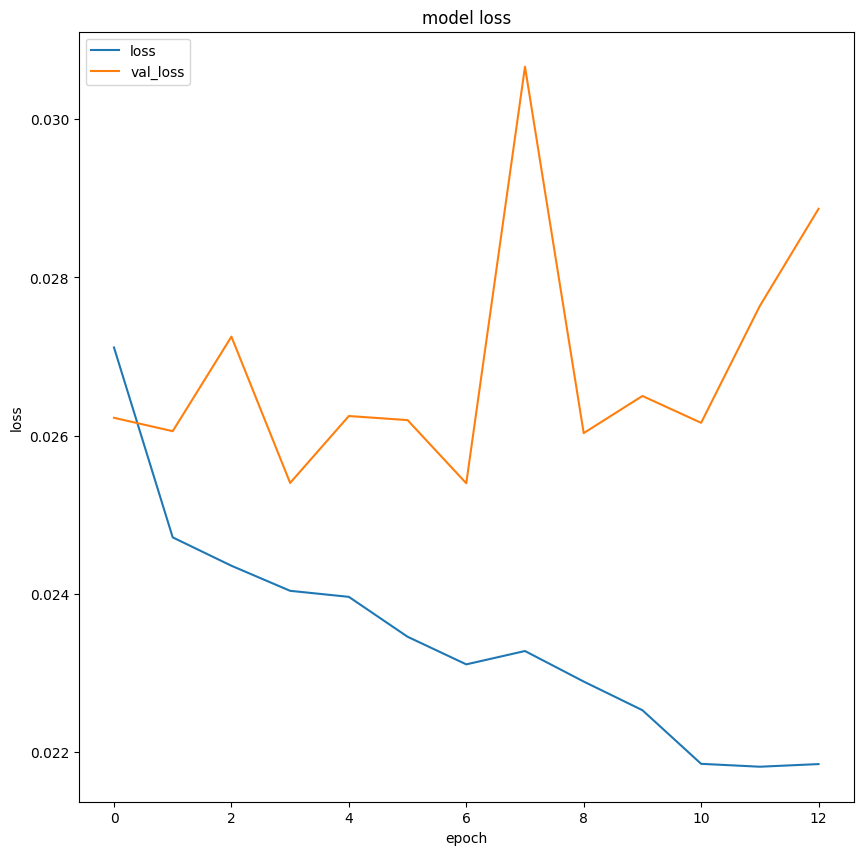

In [44]:
plot_history(hst)

### Compare the models


In [36]:
m1 = keras.saving.load_model("models/efficientNet_model_baseline.keras")
m2 = keras.saving.load_model("models/efficientNet_model_optimized.keras")
m3 = keras.saving.load_model("models/mobileNet_model_baseline.keras")
m4 = keras.saving.load_model("models/mobileNet_model_optimized.keras")

effNet_base_test = m1.evaluate(test_data)
effNet_opt_test = m2.evaluate(test_data)
mobNet_base_test = m3.evaluate(test_data)
mobNet_opt_test = m4.evaluate(test_data)

14/14 [==============================] - 3s 152ms/step - loss: 0.0241


In [39]:
print(f"{effNet_base_test=:.4f}\n\
        {effNet_opt_test=:.4f} \n\
        {mobNet_base_test=:.4f}\n\
        {mobNet_opt_test=:.4f}")

effNet_base_test=0.0278
effNet_opt_test=0.0236
mobNet_base_test=0.0382
mobNet_opt_test=mobNet_opt_test=0.0241


## Performance Evaluation

In [43]:
best_model = m2

# This is inefficient, it may take a few minutes to run
y_pred, y_true = [], []
for (img, area), y in test_data.unbatch():
    img = np.expand_dims(img, axis=0)
    area = np.expand_dims(area, axis=0)
    y_pred.append(best_model((img, area)))
    y_true.append(y) 

y_pred = np.vstack(y_pred)
y_true = np.vstack(y_true)

In [44]:
df_pred = pd.DataFrame(y_pred, columns=['translation_pred', 'rotation_pred'])
df_true = pd.DataFrame(y_true, columns=['translation_true', 'rotation_true'])
df_final = pd.concat((df_pred, df_true),axis='columns')

df_final['translation_pred'] = rescaler_transl.inverse_transform(df_final['translation_pred'].values.reshape(-1,1)).squeeze()
df_final['translation_true'] = rescaler_transl.inverse_transform(df_final['translation_true'].values.reshape(-1,1)).squeeze()

df_final['rotation_pred'] = rescaler_rot.inverse_transform(df_final['rotation_pred'].values.reshape(-1,1)).squeeze()
df_final['rotation_true'] = rescaler_rot.inverse_transform(df_final['rotation_true'].values.reshape(-1,1)).squeeze()

df_final.head()

,translation_pred,rotation_pred,translation_true,rotation_true
0,0.124833,0.010031,0.234568,0.024361
1,0.123727,0.011559,0.198844,0.022323
2,0.143907,0.012202,0.106990,0.004599
3,0.127053,0.010732,0.106020,0.001783
4,0.160325,0.012926,0.055471,0.003855


In [46]:
R2_transl = r2_score(df_final["translation_true"], df_final["translation_pred"])
R2_rot = r2_score(df_final["rotation_true"], df_final["rotation_pred"])

RMSE_transl = root_mean_squared_error(df_final["translation_true"], df_final["translation_pred"])
RMSE_rot = root_mean_squared_error(df_final["rotation_true"], df_final["rotation_pred"])

transl_delta = df_final["translation_true"].max() - df_final["translation_true"].min()
rot_delta = df_final["rotation_true"].max() - df_final["rotation_true"].min()

NRMSE_transl = RMSE_transl / transl_delta
NRMSE_rot = RMSE_rot / rot_delta

print(
    f"""{R2_transl=:.3f},\t{R2_rot=:.3f}
    {RMSE_transl=:.3f},\t{RMSE_rot=:.4f}
    {NRMSE_transl=:.3f},\t{NRMSE_rot=:.3f}"""
)

R2_transl=0.413,	R2_rot=0.037
RMSE_transl=0.091,	RMSE_rot=0.0094
NRMSE_transl=0.107,	NRMSE_rot=0.192
